# Regresion Lineal por el metodo de Ordinary Least Squares

Los modelos predictivos de Scikit-learn se definen como clases que tienen al menos cuatro métodos:
* ``__init__``: el constructor, recibe como argumentos los meta-parámetros del modelo y los almacena
* ``fit``: recibe como argumentos X e y, entrena el modelo (calcula sus parámetros) y lo devuelve.
* ``predict``: recibe como argumento X, calcula las predicciones y las devuelve.
* ``score``: recibe como argumentos X e y, realiza las predicciones sobre X y calcula con ellas el error de aproximación a y. Por defecto aplica la métrica ``r2_score`` a los modelos de regresión y la métrica ``accuracy`` a los de clasifiación.

Programa a continuación los métodos fit y predict de la regresión lineal mediante el método de Ordinary Least Squares.

In [1]:
import numpy as np
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.metrics import r2_score

class OLSLinearRegression(BaseEstimator, RegressorMixin):

    def __init__(self):
        pass

    def fit(self, X, y):
        if len(X.shape) == 1: X = X.reshape((-1, 1))
        X = np.hstack((np.ones((len(X), 1)), X))
        
        # In this case, @ is for matrix multiplication
        self.beta_ = np.linalg.inv(X.T @ X) @ X.T @ y
        return self
        
    def predict(self, X):
        # YOUR CODE HERE
        
        if len(X.shape) == 1: X = X.reshape((-1, 1))
        X = np.hstack((np.ones((len(X), 1)), X))
        
        return X @ self.beta_
    
    def score(self, X, y):
        preds = self.predict(X)
        return r2_score(y, preds)

La regresión lineal con el método de OLS ya está disponible en Scikit-learn mediante la clase ``LinearRegression`` del submódulo ``linear_model``. Si has programado el método de OLS correctamente, debería producir los mismos resultados que ``LinearRegression`` sobre los datasets de regresión de Boston Housing y Diabetes, que se obtienen con las funciones de Scikit-learn ``load_boston`` y ``load_diabetes``, respectivamente:

In [2]:
from sklearn.datasets import load_boston, load_diabetes
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

for loader in (load_boston, load_diabetes):
    X, y = loader(return_X_y=True)
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

    ols_lr = OLSLinearRegression()
    lr = LinearRegression()

    ols_lr.fit(X_train, y_train)
    lr.fit(X_train, y_train)

    ols_lr_preds = ols_lr.predict(X_test)
    lr_preds = lr.predict(X_test)
    np.testing.assert_array_almost_equal(ols_lr_preds, lr_preds, decimal=3, err_msg='Las predicciones difieren demasiado')

    ols_lr_score = ols_lr.score(X_test, y_test)
    lr_score = lr.score(X_test, y_test)
    print(loader.__name__ + ':\n\tR2 OLS: ' + str(ols_lr_score) + '\n\tR2 LS: ' + str(lr_score))
    np.testing.assert_almost_equal(ols_lr_score, lr_score, decimal=2, err_msg='Los scores difieren demasiado')

load_boston:
	R2 OLS: 0.6354638433201965
	R2 LS: 0.6354638433202128
load_diabetes:
	R2 OLS: 0.35940090989715434
	R2 LS: 0.35940090989715545


# Regresion Lineal por el metodo de Stochastic Gradient Descent

En esta ocasión debes implementar los métodos ``fit`` y ``predict`` de la regresión lineal mediante el método de descenso por gradiente estocástico:

In [3]:
import numpy as np
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.metrics import r2_score
from numpy import random

class SGDLinearRegression(BaseEstimator, RegressorMixin):

    def __init__(self, max_iter=1000, eta=0.01):
        self.max_iter = max_iter
        self.eta = eta

    def initialize(self, X):
        if len(X.shape) == 1: X = X.reshape((-1, 1))
        X = np.hstack((np.ones((len(X), 1)), X))       
        return X
        
    def fit(self, X, y):
        X = self.initialize(X)  
        
        iter_ = self.max_iter
        if( X.shape[0] < self.max_iter ):
            iter_ = X.shape[0]
        
        # Random Order
        index = random.choice(iter_,iter_,replace=False)
        X = X[index,:]
        y = y[index]
        
        # In this case, @ is for matrix multiplication
        betha = np.linalg.inv(X.T @ X) @ X.T @ y 
        gradient = self.gradient(X, y, betha, iter_)
        
        self.betha = betha - self.eta * gradient 
        return self
        
    def gradient(self, X, y, betha, iter_):
        gradient = 0
        
        for reg in range(iter_):
            gradient = ( -2 /iter_) * X[reg] * ( y[reg] - ( X[reg] * betha ) )
                   
#         gradient *= (-2/iter_)
#         return gradient
        
        return gradient
        
    
    
    def predict(self, X):
        X = self.initialize(X)  
        return X @ self.betha

    def score(self, X, y):
        preds = self.predict(X)
        return r2_score(y, preds)

Se puede comprobar si los resultados son similares a los obtenidos con el modelo ``SGDRegressor`` de Scikit-learn. En este caso hay que tomar la precaución de estandarizar los datos de entrada, ya que los métodos basados en descenso por gradiente son sensibles a la escala de las variables:

In [4]:
from sklearn.datasets import load_boston, load_diabetes
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

for loader in (load_boston, load_diabetes):
    X, y = loader(return_X_y=True)
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

    sgd_lr = Pipeline([('stds', StandardScaler()), ('sgd_lr', SGDLinearRegression())])
    sgd = Pipeline([('stds', StandardScaler()), ('sgd', SGDRegressor(penalty=None, shuffle=False, learning_rate='constant'))])

    sgd_lr.fit(X_train, y_train)
    sgd.fit(X_train, y_train)

    sgd_lr_score = sgd_lr.score(X_test, y_test)
    sgd_score = sgd.score(X_test, y_test)
    print(loader.__name__ + ':\n\tR2 SGDLR: ' + str(sgd_lr_score) + '\n\tR2 SGDR: ' + str(sgd_score))
    np.testing.assert_almost_equal(sgd_lr_score, sgd_score, decimal=1, err_msg='Los scores difieren demasiado')

load_boston:
	R2 SGDLR: 0.6351656112624102
	R2 SGDR: 0.6324450476096304
load_diabetes:
	R2 SGDLR: 0.3594169323684281
	R2 SGDR: 0.32315572923945013


c:\users\nicole guzmán cleto\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
c:\users\nicole guzmán cleto\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


# Boston Housing con redes neuronales

Una vez entendidos los modelos lineales, estamos en condiciones de probar otros modelos más expresivos como las redes neuronales. Vamos a comprobar su efectividad con un conjunto de datos clásico en Aprendizaje Automático: Boston Housing.

El dataset está disponible en la página web de UCI (https://archive.ics.uci.edu/ml/datasets/Housing), donde, aparte de descargarlo, podéis ver el tipo de variables que contiene, que es un dataset de regresión, y algunos detalles más. Por suerte para nosotros, scikit-learn ya dispone de una función que carga los datos de este dataset en nuestro espacio de trabajo:

In [5]:
from sklearn.datasets import load_boston
boston = load_boston()
print(boston.data.shape)
print(str(boston.data[0]))
print(str(boston.target[0]))

(506, 13)
[6.320e-03 1.800e+01 2.310e+00 0.000e+00 5.380e-01 6.575e+00 6.520e+01
 4.090e+00 1.000e+00 2.960e+02 1.530e+01 3.969e+02 4.980e+00]
24.0


Para poder evaluar de forma fiable los modelos, lo primero que deberíamos hacer es definir folds para cross-validation o separar una parte de los datos como conjunto de test, por ejemplo un 10% de la muestra:

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(boston.data, boston.target, test_size=0.1)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(455, 13)
(455,)
(51, 13)
(51,)


A continuación, vamos a crear el modelo base contra el que comparar nuestras redes neuronales. Dado que el problema es de regresión, lo más básico que podemos utilizar es una regresión lineal. Usaremos la ya vista anteriormente, que se entrena mediante descenso por gradiente. Estos modelos, así como los de redes neuronales, necesitan una estandarización previa de los datos, por lo que vamos a construir un pipeline de procesamiento en el que la primera componente será un estandarizador y la segunda el modelo predictivo:

In [7]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDRegressor
estimator = Pipeline([('standardizer', StandardScaler()), ('predictor', SGDRegressor())])

Ahora podemos entrenar nuestro modelo con el conjunto de datos de entrenamiento y evaluarlo con el conjunto de datos de test:

In [8]:
estimator.fit(X_train, y_train)
print(estimator.score(X_test, y_test))

0.6360770881587914


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


El resultado es mejorable, pero ya tenemos nuestro modelo base contra el que comparar. ¿Serías capaz de programar el mismo pipeline utilizando un perceptrón en lugar de una regresión lineal? La clase de scikit-learn que debes usar es sklearn.neural_network.MLPRegressor. Ten en cuenta que el número y tamaño de las capas ocultas se especifica con el meta-parámetro hidden_layer_sizes (por ejemplo, hidden_layer_sizes=() para un perceptrón simple y hidden_layer_sizes=(100, 100) para un perceptrón con dos capas ocultas de tamaño 100). Es probable que el modelo necesite muchas iteraciones de entrenamiento para converger. Puedes indicar el número máximo de iteraciones con el meta-parámetro max_iter (por ejemplo, max_iter=1000).

In [9]:
# YOUR CODE HERE
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor

mLPestimator = Pipeline([('standardizer', StandardScaler()), 
                         ('predictor', MLPRegressor(hidden_layer_sizes=(100, 100), max_iter=1000))
                        ])


mLPestimator.fit(X_train, y_train)
print(mLPestimator.score(X_test, y_test))

0.8441277387391541


Hay modelos que pueden mejorarse a través de términos de regularización. La regresión lineal se puede regularizar con un término L2, lo que nos da el modelo de regresión ridge. Las redes neuronales son los modelos más flexibles en este sentido. Vamos a ver cómo funciona un modelo ridge. Debemos especificar el coeficiente de regularización en el meta-parámetro alpha. Los valores razonables suelen estar entre 0 y 1:

In [10]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
estimator = Pipeline([('standardizer', StandardScaler()), ('predictor', Ridge(alpha=0.5))])
estimator.fit(X_train, y_train)
print(estimator.score(X_test, y_test))

0.6350819555034828


El modelo MLPRegressor también tiene un parámetro alpha. ¿Puedes probar el modelo añadiendo regularización?

In [11]:
# YOUR CODE HERE
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor

mLPestimator = Pipeline([('standardizer', StandardScaler()), 
                         ('predictor', MLPRegressor(hidden_layer_sizes=(100, 100), max_iter=1000, alpha=0.5))
                        ])


mLPestimator.fit(X_train, y_train)
print(mLPestimator.score(X_test, y_test))

0.8754142726690957


/opt/conda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Si has elegido bien el valor del coeficiente alpha, habrás visto una ligera mejora en tu modelo. Normalmente la búsqueda de meta-parámetros se automatiza con métodos como la búsqueda en rejilla o la búsqueda aleatoria. Vamos a probar la búsqueda en rejilla con el modelo ridge para su parámetro alpha:

In [12]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
estimator = Pipeline([('standardizer', StandardScaler()), ('predictor', Ridge())])
search = GridSearchCV(estimator, {'predictor__alpha': [0.0, 0.25, 0.5, 0.75, 1.0]})
search.fit(X_train, y_train)
print(search.best_params_)
print(search.score(X_test, y_test))

{'predictor__alpha': 1.0}
0.6352832859647826


/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


¿Puedes hacer lo mismo con el parámetro alpha del perceptrón multicapa? Puedes probar más valores aparte de 0, 0.25, 0.5, 0.75 y 1.

In [13]:
# YOUR CODE HERE
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV

pipe_params = {'predictor__hidden_layer_sizes': [(100, 100)],
               'predictor__max_iter': [1000],
               'predictor__alpha': [0.0, 0.25, 0.5, 0.75, 1]
              }


pipe = Pipeline([
                 ('standardizer', StandardScaler()),
                 ('predictor', MLPRegressor())
                ])

grid_search_cv = GridSearchCV(pipe, pipe_params)

grid_search_cv.fit(X_train, y_train)
print(grid_search_cv.best_params_)
print(grid_search_cv.score(X_test, y_test))

/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_ite

{'predictor__alpha': 1, 'predictor__hidden_layer_sizes': (100, 100), 'predictor__max_iter': 1000}
0.8558202915656691


# Digits con redes neuronales

Ahora vamos a experimentar con las redes neuronales en el problema Digits.

La información sobre el dataset se puede encontrar en http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html. Contiene imágenes de 8x8 píxeles de dígitos manuscritos, y el objetivo es clasificarlos correctamente dentro de las categorías de 0 a 9. Podemos descargarlo directamente utilizando scikit-learn:

In [14]:
from sklearn.datasets import load_digits
digits = load_digits()
print(digits.data.shape)
print(str(digits.data[0]))
print(str(digits.target[0]))

(1797, 64)
[ 0.  0.  5. 13.  9.  1.  0.  0.  0.  0. 13. 15. 10. 15.  5.  0.  0.  3.
 15.  2.  0. 11.  8.  0.  0.  4. 12.  0.  0.  8.  8.  0.  0.  5.  8.  0.
  0.  9.  8.  0.  0.  4. 11.  0.  1. 12.  7.  0.  0.  2. 14.  5. 10. 12.
  0.  0.  0.  0.  6. 13. 10.  0.  0.  0.]
0


Podemos ver qué tipo de imágenes hay en el dataset:

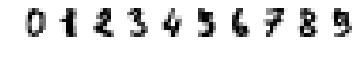

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline
num_images = 10
for index, image in enumerate(digits.images[:num_images]):
    plt.subplot(2, num_images, index + num_images + 1)
    plt.axis('off')
    plt.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
plt.show()

Como siempre, lo correcto es hacer folds para cross-validation o al menos separar algunos patrones para test:

In [16]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(digits.data, digits.target, test_size=0.1)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1617, 64)
(1617,)
(180, 64)
(180,)


Vamos a probar qué tal resuelve este problema de clasificación un perceptrón simple con alpha=0.1 (http://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html):

In [17]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
estimator = Pipeline([('standardizer', StandardScaler()), ('predictor', MLPClassifier(hidden_layer_sizes=(), alpha=0.1, max_iter=10000))])
estimator.fit(X_train, y_train)
print(estimator.score(X_test, y_test))

0.9555555555555556


Scikit-learn está bastante limitado a la hora de experimentar con redes neuronales, ya que no permite crear redes de tipo convolucional o recurrente. Este problema tiene claramente una estructura espacial (los píxeles de cada imagen están colocados de una determinada forma, y su orden es importante), por lo que probablemente una red convolucional sea capaz de mejorar los resultados. Para probar este tipo de modelos, podemos utilizar la librería Keras (https://keras.io/):

In [18]:
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D
from keras.utils import to_categorical
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam

K.set_image_data_format('channels_first')

input_shape = (1, 8, 8)
X_train_keras = X_train.reshape(X_train.shape[0], *input_shape)
X_test_keras = X_test.reshape(X_test.shape[0], *input_shape)
X_train_keras = X_train_keras.astype('float32')
X_test_keras = X_test_keras.astype('float32')
X_train_keras /= 16
X_test_keras /= 16
num_classes = 10
y_train_keras = to_categorical(y_train, num_classes)
y_test_keras = to_categorical(y_test, num_classes)

model = Sequential()
model.add(Conv2D(32, kernel_size=(2, 2), activation='relu', input_shape=(1, 8, 8)))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=categorical_crossentropy, optimizer=Adam(), metrics=['accuracy'])
model.fit(X_train_keras, y_train_keras, batch_size=32, epochs=1000, verbose=0, validation_split=0.1)
score = model.evaluate(X_test_keras, y_test_keras, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Test loss: 0.3524875437169764
Test accuracy: 0.9611111111111111


La red convolucional que acabamos de construir tiene únicamente una capa convolucional y una capa "normal" (fully-connected, densa). Podemos mejorar los resultados modificándola para que tenga dos capas convolucionales seguidas de dos capas densas. ¿Puedes hacerlo? Ten en cuenta que hay que controlar el tamaño de los kernels de las convoluciones (en este caso usamos (2, 2). Puedes ver documentación al respecto en http://deeplearning.net/tutorial/lenet.html.

In [22]:
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.utils import to_categorical
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam

K.set_image_data_format('channels_first')

input_shape = (1, 8, 8)
X_train_keras = X_train.reshape(X_train.shape[0], *input_shape)
X_test_keras = X_test.reshape(X_test.shape[0], *input_shape)
X_train_keras = X_train_keras.astype('float32')
X_test_keras = X_test_keras.astype('float32')
X_train_keras /= 16
X_test_keras /= 16
num_classes = 10
y_train_keras = to_categorical(y_train, num_classes)
y_test_keras = to_categorical(y_test, num_classes)

model = Sequential()

# Construct the first convolutional pooling layer:
# maxpooling reduces this to (8/2, 8/2) = (4, 4)
model.add(Conv2D(32, kernel_size=(2, 2), activation='relu', input_shape=(1, 8, 8)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(Conv2D(32, kernel_size=(2, 2), activation='relu'))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=categorical_crossentropy, optimizer=Adam(), metrics=['accuracy'])
model.fit(X_train_keras, y_train_keras, batch_size=32, epochs=1000, verbose=0, validation_split=0.1)
score = model.evaluate(X_test_keras, y_test_keras, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.039126358015669715
Test accuracy: 0.9944444444444445
